In [1]:
import numpy as np 
from keras.models import * 
from keras.layers import * 
from keras.optimizers import * 
from keras.datasets import mnist 
import keras.backend as K 
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
%matplotlib inline

K.set_image_data_format('channels_last') 

Using TensorFlow backend.


In [2]:
class Gan: 
    def __init__(self, img_data): 
        img_size = img_data.shape[1] 
        channel = img_data.shape[3] if len(img_data.shape) >= 4 else 1 
        
        self.img_data = img_data 
        self.input_shape = (img_size, img_size, channel) 
        
        self.img_rows = img_size 
        self.img_cols = img_size 
        self.channel = channel 
        self.noise_size = 100 
        
        self.create_d() 
        self.create_g() 

        optimizer = Adam(lr=0.0008) 
        self.D.compile(loss='binary_crossentropy', optimizer=optimizer) 

        optimizer = Adam(lr=0.0004) 
        self.D.trainable = False 
        self.AM = Sequential() 
        self.AM.add(self.G) 
        self.AM.add(self.D) 
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.AM.summary()
    
    def create_d(self): 
        self.D = Sequential() 
        depth = 64 
        dropout = 0.4 
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same')) 
        self.D.add(LeakyReLU(alpha=0.2)) 
        self.D.add(Dropout(dropout)) 
        self.D.add(Flatten()) 
        self.D.add(Dense(1)) 
        self.D.add(Activation('sigmoid')) 
        #self.D.summary() 
        return self.D 
        
    def create_g(self): 
        self.G = Sequential() 
        dropout = 0.4 
        depth = 64+64+64+64 
        dim = 7 
        self.G.add(Dense(dim*dim*depth, input_dim=self.noise_size)) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Reshape((dim, dim, depth))) 
        self.G.add(Dropout(dropout)) 
        self.G.add(UpSampling2D()) 
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(UpSampling2D()) 
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same')) 
        self.G.add(BatchNormalization(momentum=0.9)) 
        self.G.add(Activation('relu')) 
        self.G.add(Conv2DTranspose(1, 5, padding='same')) 
        self.G.add(Activation('sigmoid')) 
        #self.G.summary() 
        return self.G 
        
    def train(self, batch_size=100): 
        # 60000개의 MNIST x_train Data에서 batch_size 만큼 랜덤 추출 
        images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :] 
        # -1~ 1 사이의 분포된 100개의 100차원의 랜덤값 
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
        # Generator 평가는 noise 데이터로 (가짜데이터)
        images_fake = self.G.predict(noise) 
         
        # 진짜와 가짜를 한번에 셋팅
        x = np.concatenate((images_train, images_fake)) 
        # batch_size 만큼의 진짜와 가짜를 이어서 200개 의 1 이라는 y(label) 생성
        y = np.ones([2*batch_size, 1]) 
        # 100개~ 뒤 까지는 images_fake 데이터이니까 0 으로 설정
        y[batch_size:, :] = 0 
        # 학습설정 True
        self.D.trainable = True
        # x(진짜+가짜) y(진짜라벨+가짜라벨) 에 대한 한번의 loss값 
        d_loss = self.D.train_on_batch(x, y) 
        
        # AM을 학습
        y = np.ones([batch_size, 1]) # 100개는 1 
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
        # AM을 학습진행할때는 Dicriminator는 학습 False
        self.D.trainable = False 
        # 입력의 noise는 전부 가짜(1)라고 학습 
        a_loss = self.AM.train_on_batch(noise, y) 
        return d_loss, a_loss, images_fake

    def save(self): 
        self.G.save_weights('gan_g_weights.h5') 
        self.D.save_weights('gan_d_weights.h5') 
    
    def load(self): 
        if os.path.isfile('gan_g_weights.h5'): 
            self.G.load_weights('gan_g_weights.h5') 
            print("Load G from file.") 
        if os.path.isfile('gan_d_weights.h5'): 
            self.D.load_weights('gan_d_weights.h5') 
            print("Load D from file.")

#출처: https://neurowhai.tistory.com/273?category=605395 [NeuroWhAI의 잡블로그]

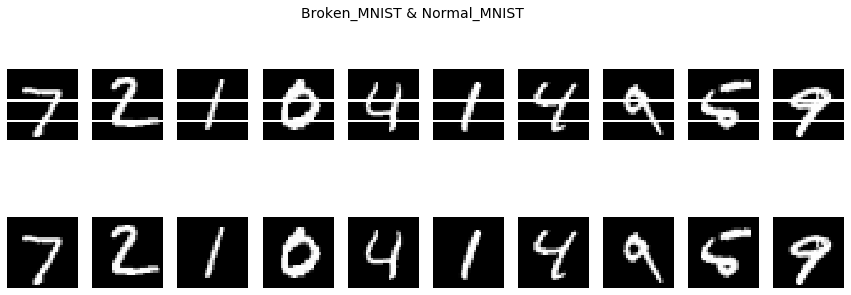

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [3]:
# MNIST dataset load
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train 0~1 normalization & reshape
x_train = x_train.reshape((x_train.shape[0],) + (28, 28, 1)).astype('float32') 
x_train = x_train / 255. 

# x_test 0~1 normalization & reshape
x_test = x_test.reshape((x_test.shape[0],) + (28, 28, 1)).astype('float32') 
x_test = x_test / 255. 

# broken MNIST & nomarl MNIST
fail_test = x_test[ :1000].copy()
real_test = x_test[ :1000].copy()
fail_test[: , 12 , :] = 1.
fail_test[: , 20 , :] = 1.

# cross fail_test_set
# fail_test[:,3,5:15] = 1
# fail_test[:,1:10,5:10] = 1

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('Broken_MNIST & Normal_MNIST', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(fail_test[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(real_test[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

gan = Gan(x_train)

load
300/300 [==============================] - 0s 497us/step


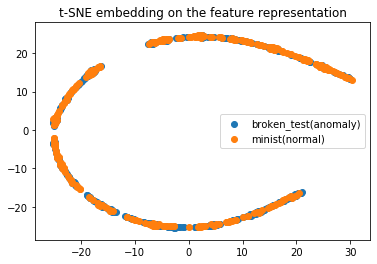

In [4]:
from sklearn.manifold import TSNE


dis = gan.create_d()
dis.load_weights('gan_d_weights.h5')
print('load')

feature_map_of_random = dis.predict(fail_test[:300], verbose=1) # broken 100개
feature_map_of_minist = dis.predict(real_test[:300], verbose=1) # x_test 300개

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:300,0], X_embedded[:300,1], label='broken_test(anomaly)')
plt.scatter(X_embedded[300:,0], X_embedded[300:,1], label='minist(normal)')
plt.legend()
plt.show()
plt.close()
